# Lab5 - Using link functions to create generalized linear models

Justyna Gibas 403122

In [59]:
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import pandas as pd  

In [60]:
flight_data = pd.read_csv('Airline_data.csv')
flight_data.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [61]:
R=1000
model_prior=CmdStanModel(stan_file='flight_prior.stan')
data_prior=dict(M=len(flight_data),miles_mean=flight_data['Miles flown [100 mln miles]'].mean())
sim=model_prior.sample(data=data_prior,
                        fixed_param=True, 
                        iter_sampling=R, 
                        iter_warmup=0, 
                        chains=1, 
                        refresh=R,
                        seed=29042020)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


While selection prior parameters for model I tried to scale mean and std of flight accidents using natural logarithm. It work badly due to too large parameters. I make coefficient alpha less spread out, because its value make model predict over 1.5 thousand accidents per year. I also make an impact of flight miles less significant.

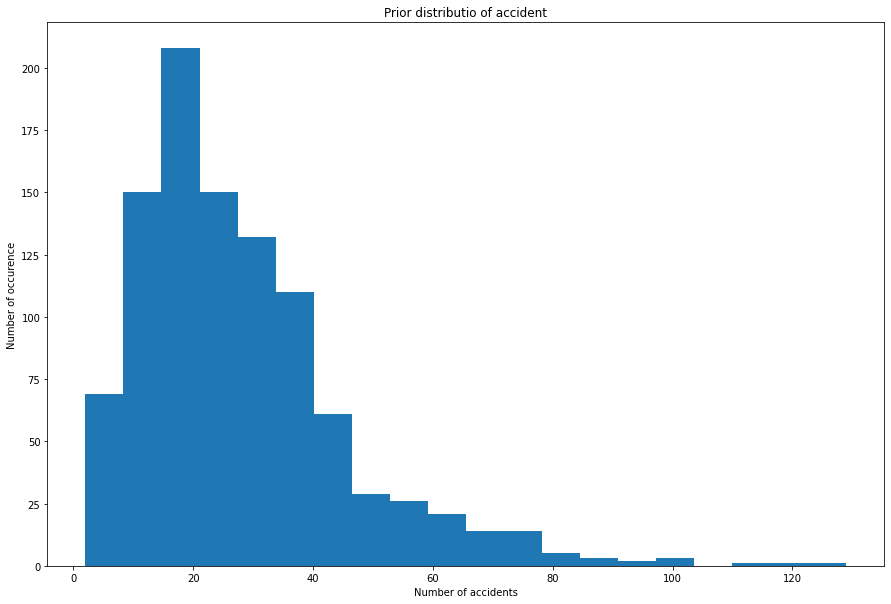

Mean number of accidents pre year: 28.016


In [62]:
prior = sim.draws_pd()
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(prior['y'], bins=20)
ax.set_title('Prior distributio of accident')
ax.set_xlabel('Number of accidents')
ax.set_ylabel('Number of occurence')
plt.show()
print('Mean number of accidents pre year: {0}'.format(prior['y'].mean()))

In [69]:
model_posterior=CmdStanModel(stan_file='flight_posterior_mean.stan')
data_posterior=dict(M=len(flight_data), miles=flight_data['Miles flown [100 mln miles]'].to_numpy(), y=flight_data["Fatal accidents"].values)
sim=model_posterior.sample(data=data_posterior)

INFO:cmdstanpy:compiling stan file /home/DA_2023/lab5/flight_posterior_mean.stan to exe file /home/DA_2023/lab5/flight_posterior_mean
INFO:cmdstanpy:compiled model executable: /home/DA_2023/lab5/flight_posterior_mean
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/DA_2023/lab5/flight_posterior_mean.hpp /home/DA_2023/lab5/flight_posterior_mean.stan
Warning in '/home/DA_2023/lab5/flight_posterior_mean.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/DA_2023/lab5/flight_posterior_mean.stan', line 21, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format f

INFO:cmdstanpy:CmdStan done processing.


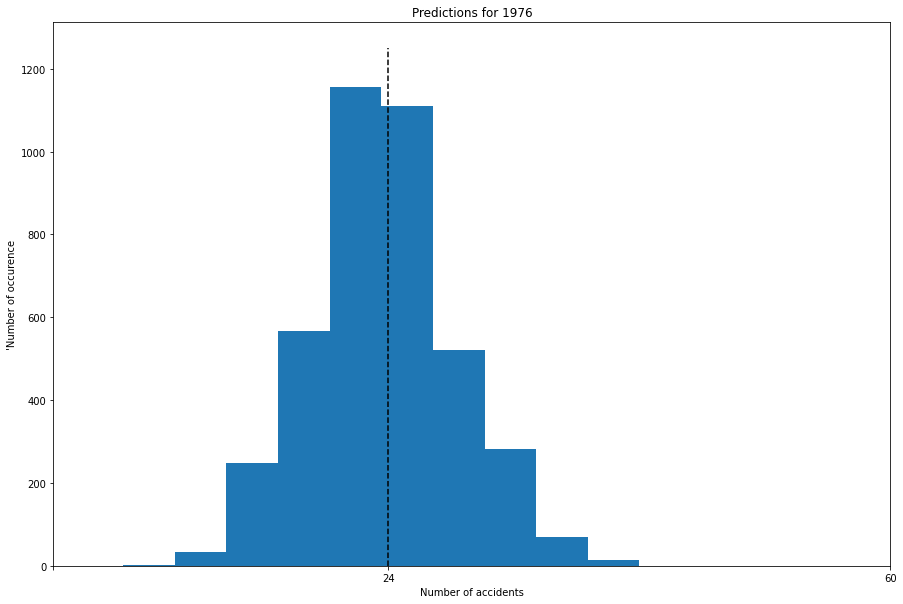

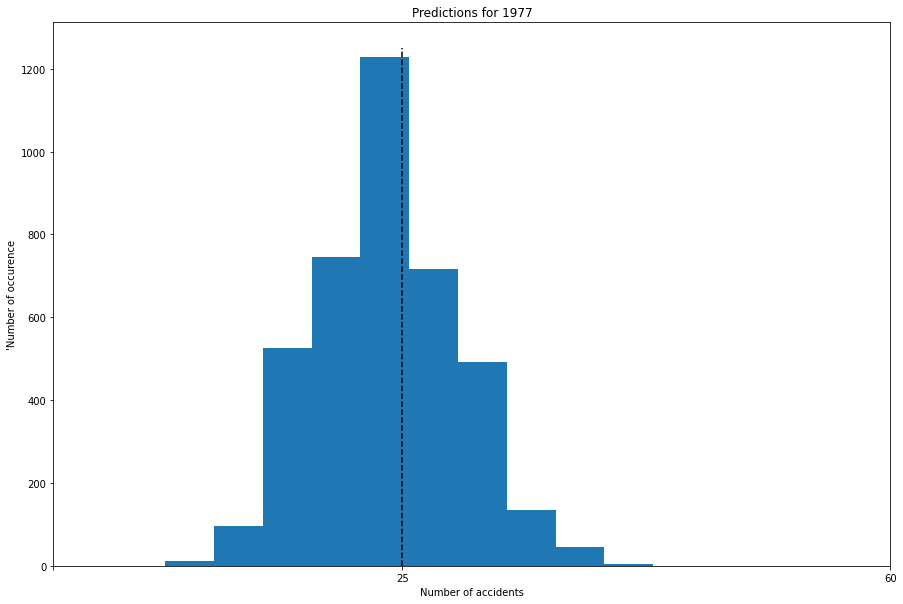

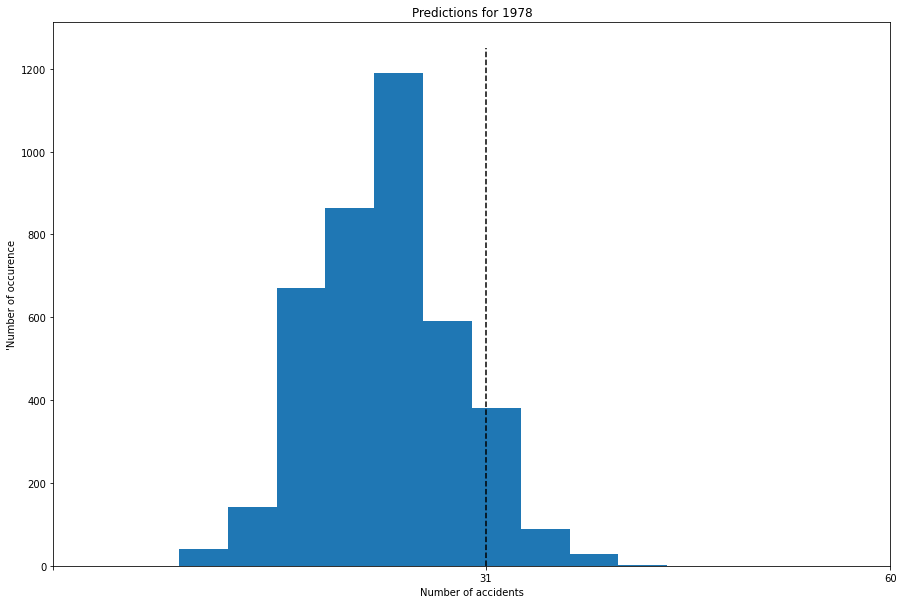

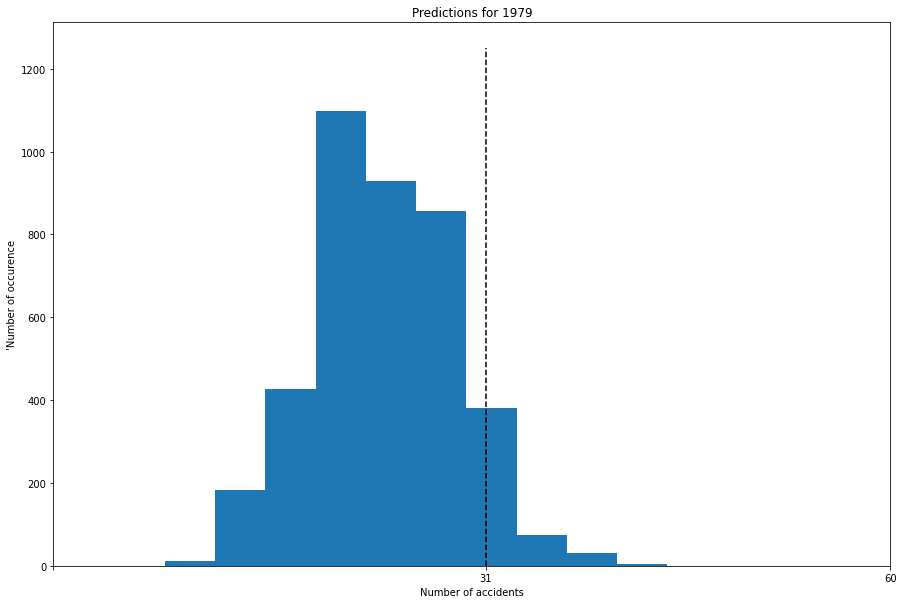

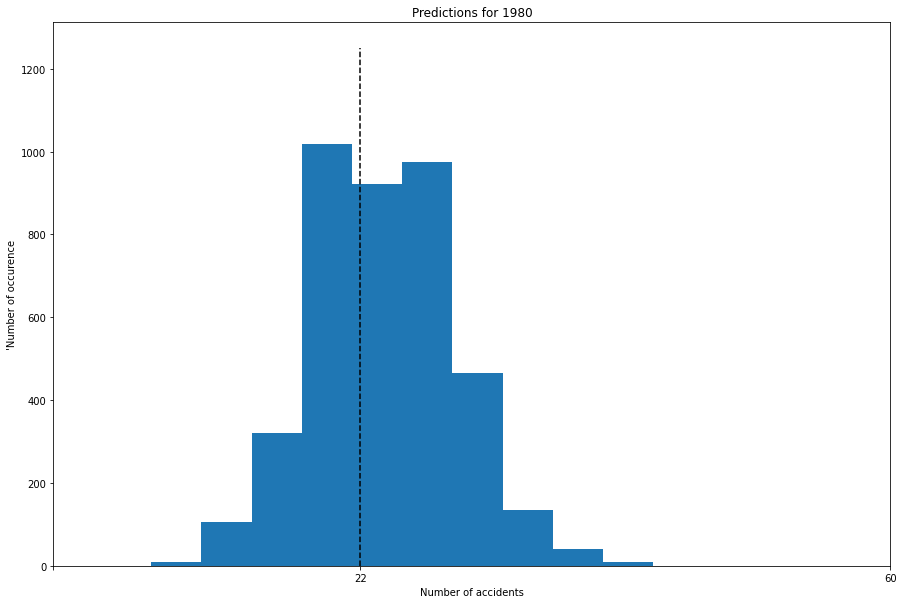

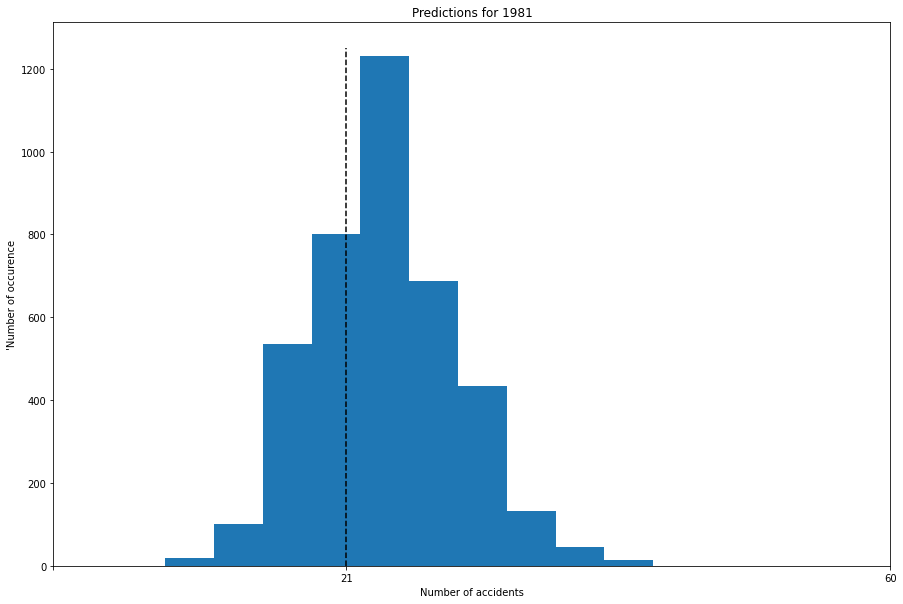

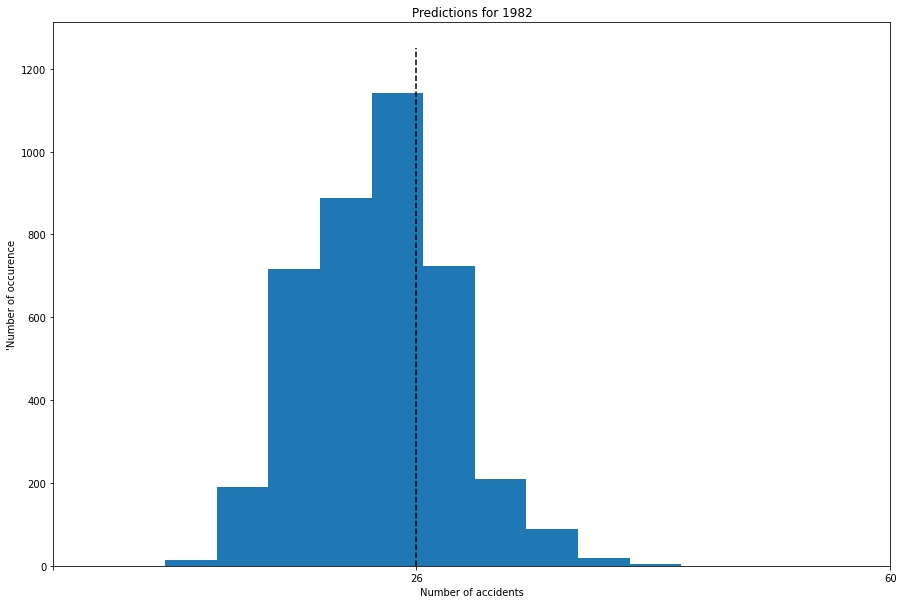

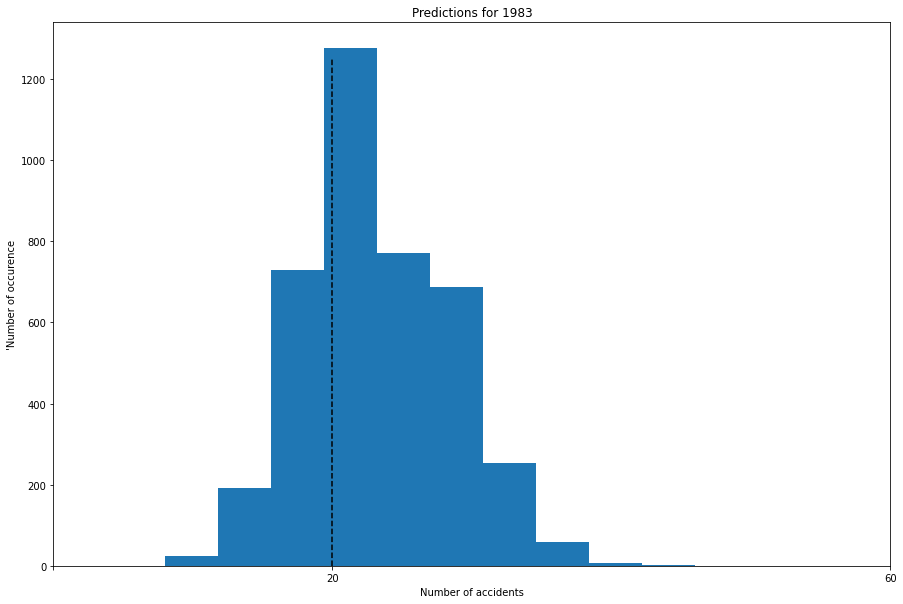

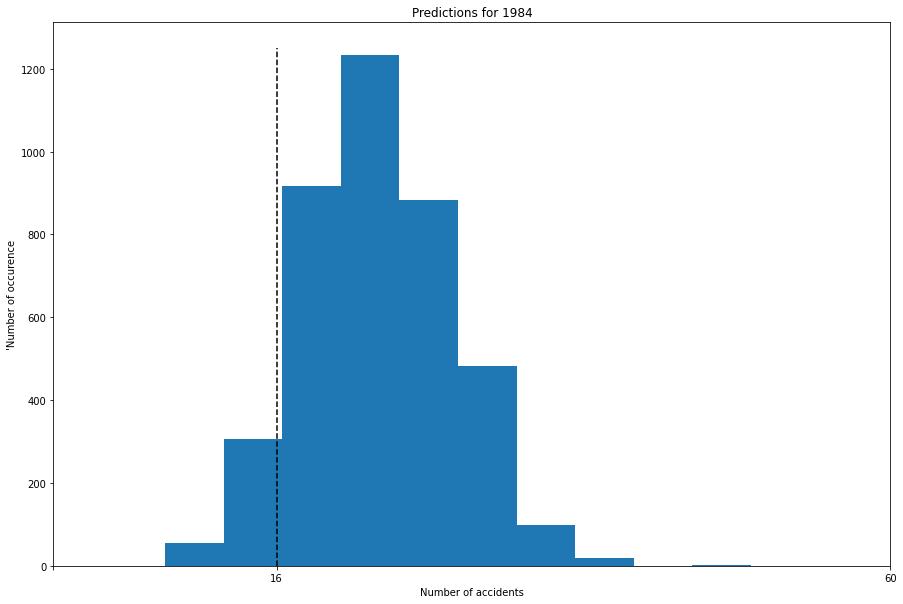

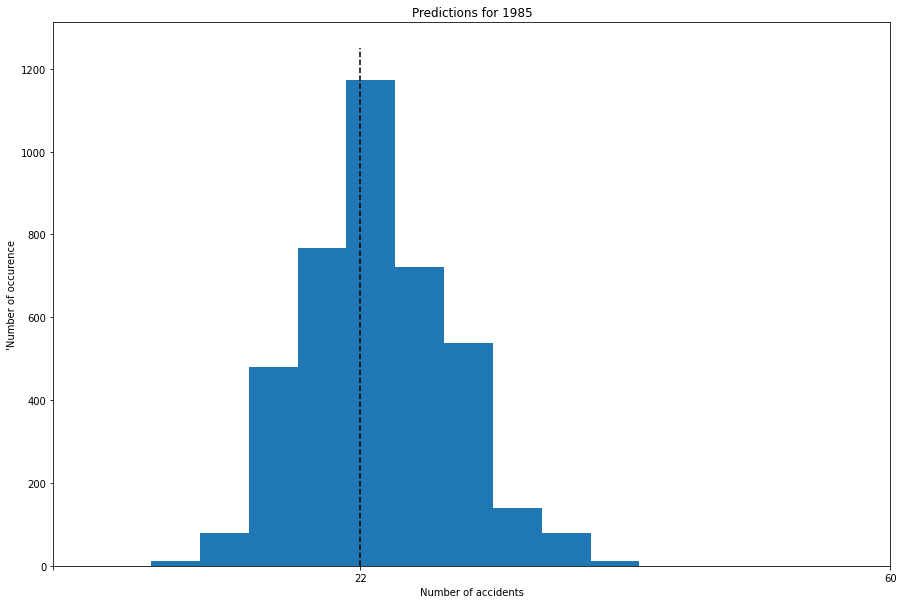

In [70]:
posterior_mean = sim.draws_pd()
for year in range(1, 11):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.hist(posterior_mean["y_sim[{0}]".format(year)])
    ax.set_title("Predictions for {0}".format(1975+year))
    ax.set_xlabel("Number of accidents")
    ax.set_ylabel("'Number of occurence")
    real_accidents = flight_data['Fatal accidents'].iloc[year-1]
    ax.plot([real_accidents,real_accidents],[0,1250],linestyle='--',color='black')
    ax.set_xticks([0,real_accidents,60])
    ax.set_xticklabels(['',real_accidents,60])
    plt.show()

Prediction are quite good. It was necessary to set lower boundary for alpha coefficient. Otherwise model produces abnormal number of prediction as zero accidents.

In [71]:
model_posterior=CmdStanModel(stan_file='flight_posterior.stan')
data_posterior=dict(M=len(flight_data), miles=flight_data['Miles flown [100 mln miles]'].to_numpy(), y=flight_data["Fatal accidents"].values)
sim=model_posterior.sample(data=data_posterior)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:07 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)





INFO:cmdstanpy:CmdStan done processing.


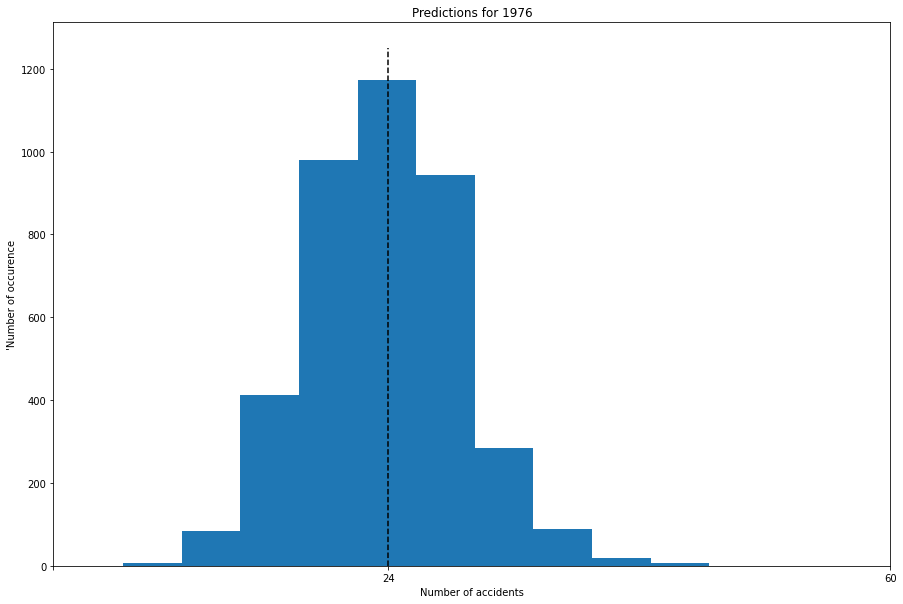

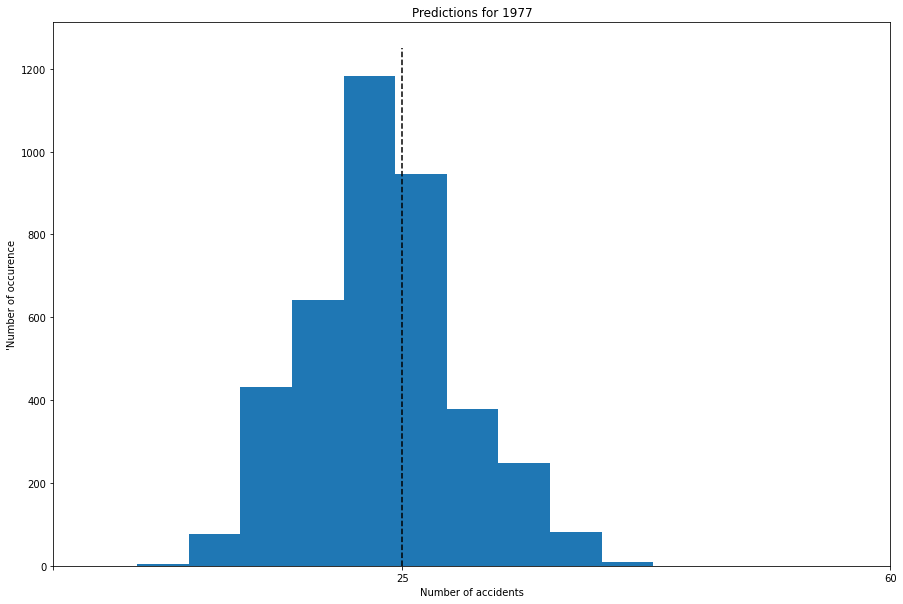

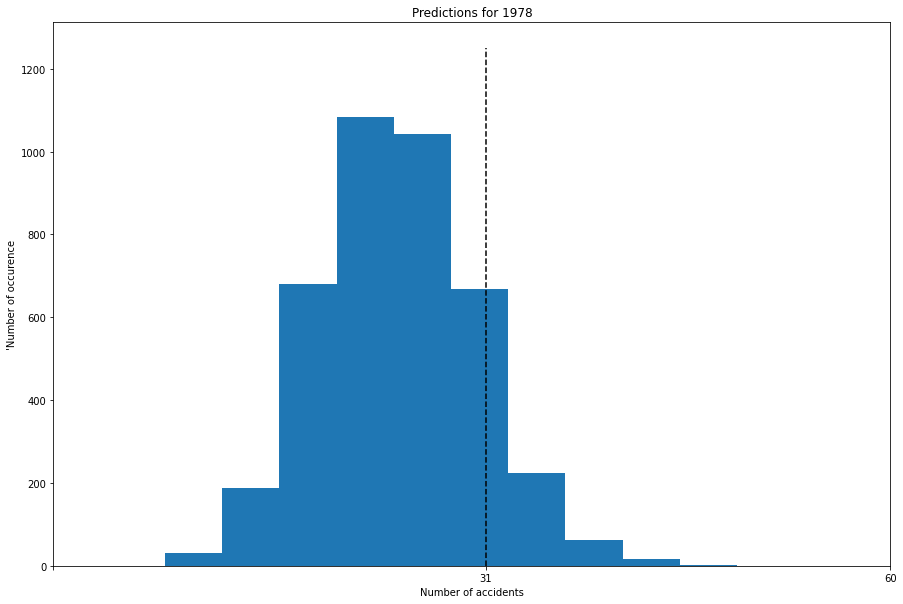

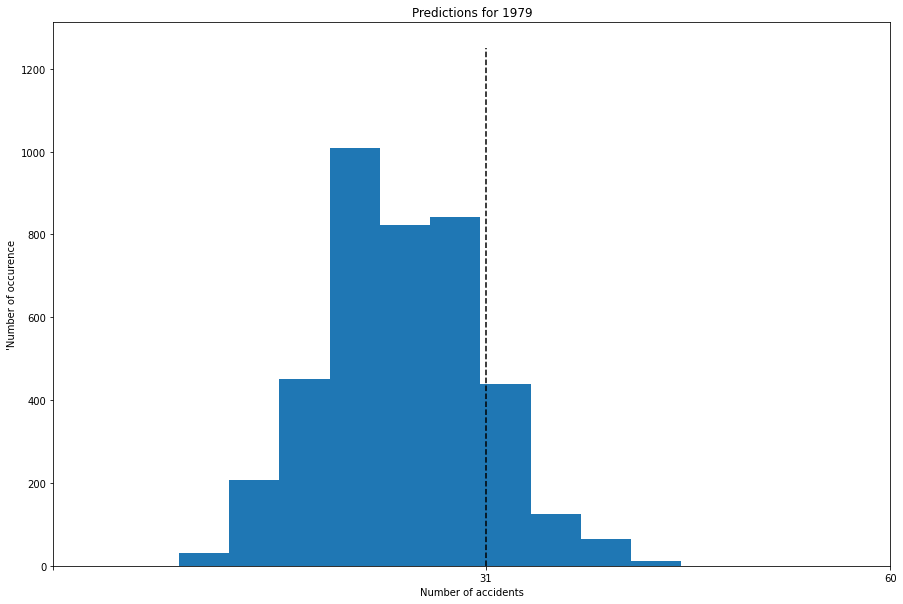

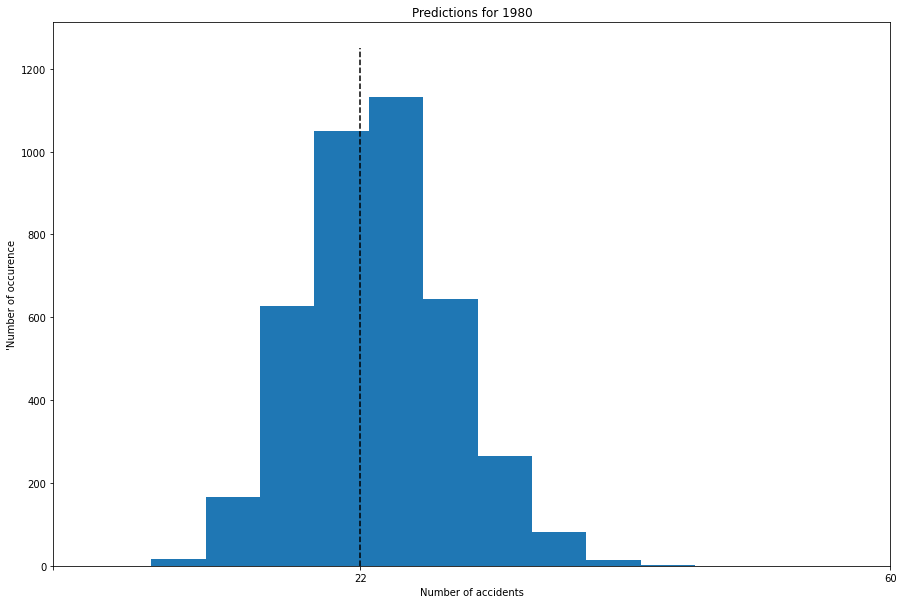

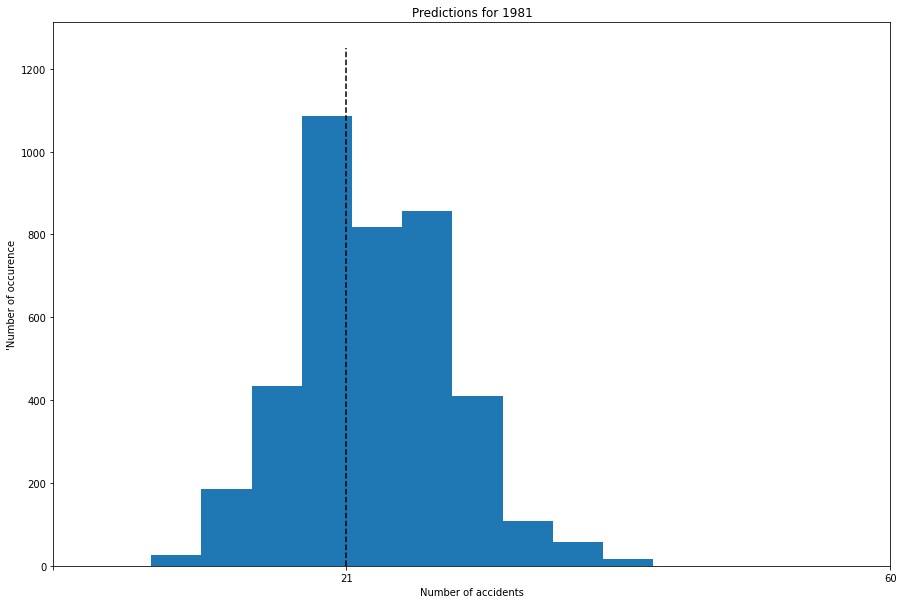

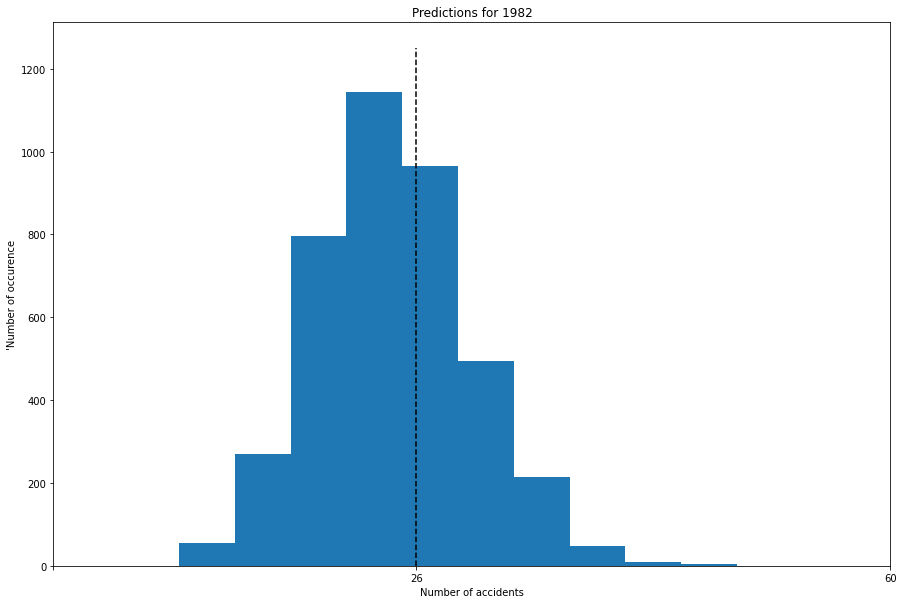

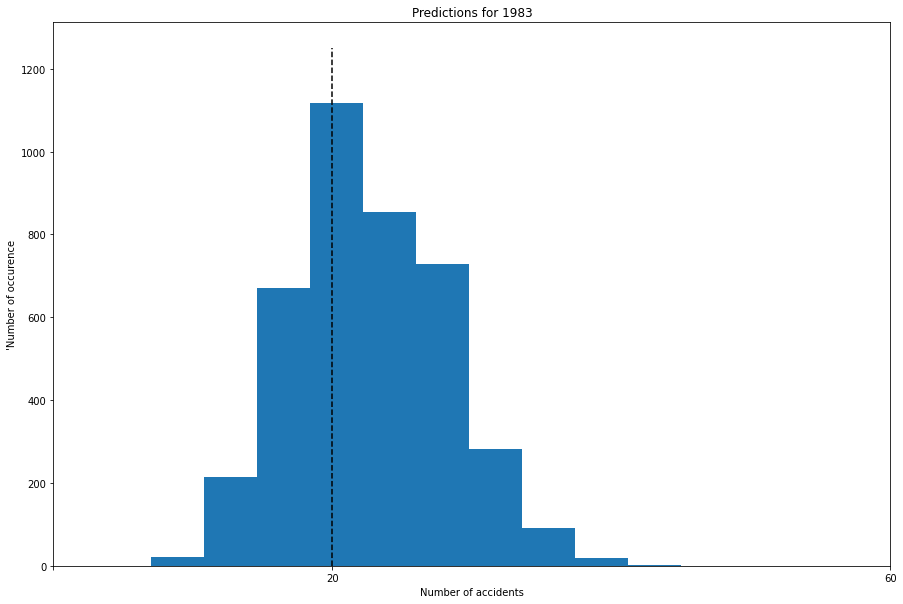

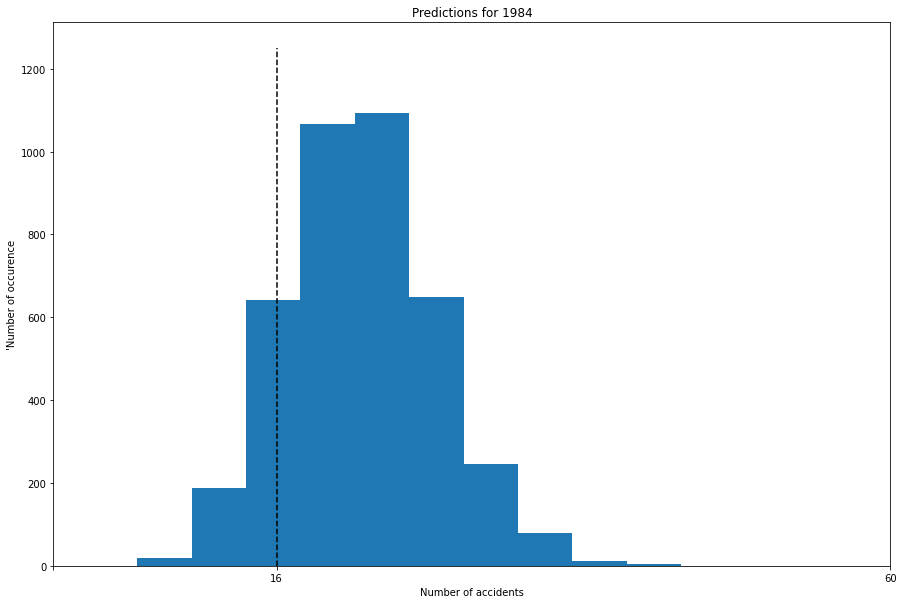

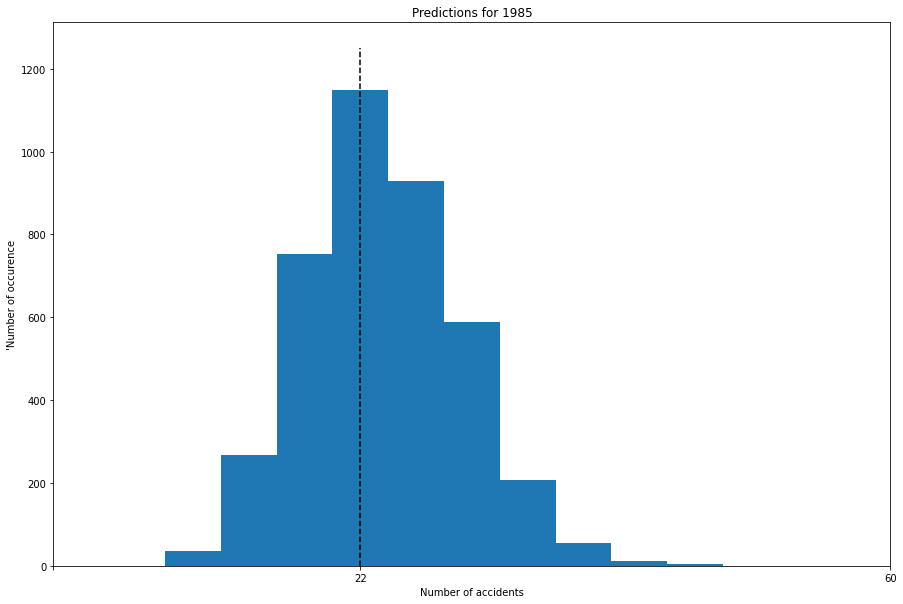

In [68]:
posterior = sim.draws_pd()
for year in range(1, 11):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.hist(posterior["y_sim[{0}]".format(year)])
    ax.set_title("Predictions for {0}".format(1975+year))
    ax.set_xlabel("Number of accidents")
    ax.set_ylabel("'Number of occurence")
    real_accidents = flight_data['Fatal accidents'].iloc[year-1]
    ax.plot([real_accidents,real_accidents],[0,1250],linestyle='--',color='black')
    ax.set_xticks([0,real_accidents,60])
    ax.set_xticklabels(['',real_accidents,60])
    plt.show()

Predictionas are even beeter than when cofficient alpha was same for all years. In most cases real number of accidents meet the most frequently predicted value. The problem with frequently predicting zero as number of accident not occured for individual coefficient.